<a href="https://colab.research.google.com/github/helincesxyz/ChatGPT-Cheater-Detection-in-Online-Games/blob/main/ChatGPTCheaterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necesessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.api as sm
from scipy import stats


# PART 1: Read And Normalize Data

In [ ]:
# read the data
df = pd.read_csv('memoire.csv', sep=';', header=0, index_col = 0 )

In [ ]:
# Remove missing values
df = df.replace('?', np.nan).dropna()
df = df.dropna()

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
# check the data for more accuracy
# get the number of variables (columns)
num_vars = df.shape[1]

# print the number of variables
print('The number of variables is:', num_vars)

num_rows = df.shape[0]

# print the number of rows
print('The number of rows is:', num_rows)

# print the first 5 rows of the data frame to check if it was read correctly
print(df.head())

The number of variables is: 26
The number of rows is: 7263
      Score     Kills    Deaths    K/D      Damage  Headshots  Dominations  \
0   90825.0   64010.0   43415.0   1.47   5469199.0    30791.0        159.0   
1   37177.0   23354.0   16610.0   1.41  12424189.0     5104.0       2956.0   
2  175099.0  377607.0  340137.0   1.11  11308366.0    66327.0        218.0   
3   20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   34534577.0   
4   54966.0   18610.0   27416.0   0.68   2430503.0     5269.0       2141.0   

   Shots Fired  Shots Hit  Shots Accuracy  ...  Hostages Rescued      MVP  \
0     445411.0    92913.0            20.9  ...             501.0   9954.0   
1    2156088.0  1385405.0            64.3  ...             807.0   1626.0   
2    1022660.0   591692.0            57.9  ...             531.0  46023.0   
3     216841.0    98468.0            45.4  ...           93455.0   2180.0   
4     294100.0    73146.0            24.9  ...            2138.0   3346.0   

      Win

In [ ]:
# Convert data to float
df = df.astype(str) # convert to strings first
df = df.apply(lambda x: x.str.replace(',', '.')).astype(float)

In [ ]:

# create the correlation matrix
corr_matrix = df.corr()

# round the values in the matrix to 2 decimal places
corr_matrix = corr_matrix.round(2)

# print the correlation matrix
print(corr_matrix)

# export the correlation matrix as a CSV file with 2 digits of accuracy
corr_matrix.to_csv('correlation.csv', float_format='%.2f', index=False)


with open("correlation.csv", "r") as f:
    content = f.read()



                      Score  Kills  Deaths   K/D  Damage  Headshots  \
Score                  1.00   0.11    0.12 -0.01    0.08       0.09   
Kills                  0.11   1.00    0.87  0.11    0.59       0.83   
Deaths                 0.12   0.87    1.00 -0.09    0.59       0.81   
K/D                   -0.01   0.11   -0.09  1.00   -0.00       0.02   
Damage                 0.08   0.59    0.59 -0.00    1.00       0.55   
Headshots              0.09   0.83    0.81  0.02    0.55       1.00   
Dominations           -0.00   0.03   -0.01  0.18    0.00      -0.00   
Shots Fired            0.04   0.41    0.29  0.08    0.21       0.27   
Shots Hit              0.03   0.19    0.20 -0.01    0.14       0.18   
Shots Accuracy         0.03   0.06    0.01  0.30    0.05       0.20   
Snipers Killed         0.01   0.08    0.04  0.18    0.04       0.04   
Domination Overkills   0.08   0.24    0.15  0.16    0.17       0.22   
Domination Revenges    0.08   0.26    0.25  0.04    0.19       0.18   
Bombs 

# PART 2: Application Of Machine Learning Models

MAHALONOBIS

In [ ]:
#MAHALONOBIS

# estimate the center and covariance matrix using the MCD estimator

mcd = MinCovDet().fit(df)
center = mcd.location_
covariance = mcd.covariance_


mcd = MinCovDet(support_fraction=0.99999)

# print the covariance matrix
print("Covariance matrix:\n", covariance)

# print the center
print("Center of the data:\n", center)


Covariance matrix:
 [[ 4.30780725e+09  1.26138263e+09  1.12416464e+09 -9.78192070e+02
   1.80796828e+11  5.06632186e+08  1.28252094e+07  2.17344617e+10
   4.27782470e+09  1.32686984e+03  8.46132117e+07  1.29845772e+07
   3.69958987e+06  5.59664279e+07  1.26081427e+07  3.05916504e+12
   1.89763922e+05  1.28112011e+08  2.34094520e+07 -6.94613939e+02
   5.57298215e+07  3.23203695e+07  1.08349998e+09  2.34094520e+07
  -4.21289348e+03  2.67851117e+04]
 [ 1.26138263e+09  4.49662713e+08  4.06226096e+08 -4.76592068e+02
   6.47830347e+10  1.82374315e+08  2.93624108e+06  7.84733962e+09
   1.52262646e+09 -3.04711780e+03  2.94636520e+07  2.98390734e+06
   8.46902180e+05  2.11096427e+07  4.82706217e+06  1.18750278e+12
   9.31182073e+04  4.95996719e+07  8.75958490e+06 -5.04299641e+01
   1.98102047e+07  1.10506198e+07  4.17357303e+08  8.75958490e+06
   2.97119565e+04  1.33037621e+04]
 [ 1.12416464e+09  4.06226096e+08  3.85454391e+08 -1.26341763e+03
   5.86949816e+10  1.63709518e+08  2.38983048e+06  7

In [ ]:
mcd = MinCovDet(support_fraction=0.99999).fit(df)
center = mcd.location_
covariance = mcd.covariance_

# Calculate the Mahalanobis distance for each observation
distances = []
for i in range(len(df)):
    x = df.iloc[i].values
    try:
        distance = mahalanobis(x, center, np.linalg.inv(covariance))
    except np.linalg.LinAlgError:
        # Handle the case of a singular matrix
        distance = np.nan
    if np.isnan(distance):
        distance = np.nanmean(distances)
    distances.append(distance)

# Print the distances
print("Mahalanobis distances:\n", distances)


/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Mahalanobis distances:
 [2333.287600279036, 2006.7693236305315, 998.4320641565994, 434054.6490894534, 923.7164292334884, 907.6560171595055, 868.0742713186005, 840.1796943814252, 724.3470286881997, 724.7921098169569, 2333.287600279036, 2006.7693236305315, 998.4320641565994, 434054.6490894534, 923.7164292334884, 868.0742713186005, 840.1796943814252, 724.3470286881997, 724.7921098169569, 432.13789714172776, 389.0197737703519, 198.21588571338933, 193.74815023885807, 181.9336459519388, 158.6484408272208, 167.7022405684185, 5887.77402740507, 141.61737240039918, 139.67512574899393, 118.66046475900943, 8934.00987477796, 120.65697103901465, 100.02999979700105, 156.47148067127338, 129.6874844253841, 121.18272975332688, 2930.6956387347022, 760.153670987832, 64.10186096351018, 1901.4826972359888, 3763.4809276196584, 70.54076161173735, 79.8997711479772, 52.62932599771535, 1434.3162551162693, 80.33613027594406, 708.691764165155, 54.34019965062663, 159.3162509808341, 183.9153343856908, 25.42378969228

In [ ]:
# replace missing values with the mean value
distances_no_missing = np.nan_to_num(distances, nan=np.nanmean(distances))

# calculate descriptive statistics of distances with missing values replaced
distances_mean = np.mean(distances_no_missing)
distances_std = np.std(distances_no_missing)
distances_min = np.min(distances_no_missing)
distances_max = np.max(distances_no_missing)
distances_25th_percentile = np.percentile(distances_no_missing, 25)
distances_50th_percentile = np.percentile(distances_no_missing, 50)
distances_75th_percentile = np.percentile(distances_no_missing, 75)

# print the descriptive statistics
print("Mean distance:", distances_mean)
print("Standard deviation of distance:", distances_std)
print("Minimum distance:", distances_min)
print("Maximum distance:", distances_max)
print("25th percentile of distance:", distances_25th_percentile)
print("50th percentile of distance:", distances_50th_percentile)
print("75th percentile of distance:", distances_75th_percentile)

Mean distance: 227.81081418385088
Standard deviation of distance: 7219.6447112841715
Minimum distance: 0.03516460695910943
Maximum distance: 434054.6490894534
25th percentile of distance: 4.309601953445405
50th percentile of distance: 8.064623460725725
75th percentile of distance: 23.608799780850568


In [ ]:
# get the indices of the sorted distances_no_missing array
sorted_indices = np.argsort(distances_no_missing)

# print the top 10 values
print("Top 10 distances_no_missing values:")
for i in range(10):
    idx = sorted_indices[-(i+1)]
    value = distances_no_missing[idx]
    print("{}. {}".format(i+1, value))

# print the bottom 10 values
print("\nBottom 10 distances_no_missing values:")
for i in range(10):
    idx = sorted_indices[i]
    value = distances_no_missing[idx]
    print("{}. {}".format(i+1, value))

Top 10 distances_no_missing values:
1. 434054.6490894534
2. 434054.6490894534
3. 19272.13546487708
4. 13938.913672040855
5. 11802.68122676124
6. 9962.651169578761
7. 8934.00987477796
8. 7786.016837476852
9. 7427.247198482455
10. 7000.144314609469

Bottom 10 distances_no_missing values:
1. 0.03516460695910943
2. 0.11700064311539769
3. 0.19569762571364313
4. 0.2583408110053163
5. 0.26806422136034996
6. 0.2718971727610509
7. 0.2998529502062605
8. 0.3043783179097435
9. 0.39052744286129204
10. 0.3972398195432255


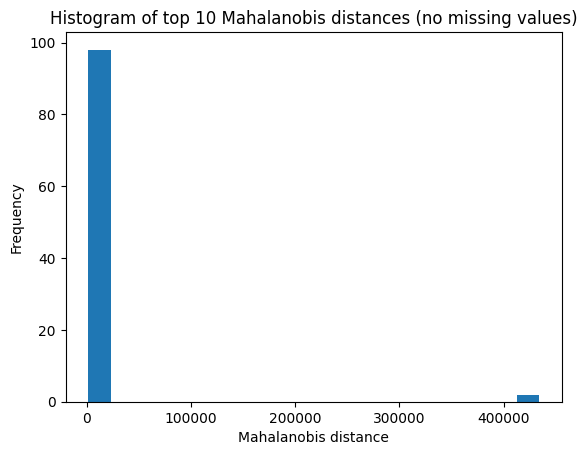

In [ ]:
# get the indices of the sorted distances_no_missing array
sorted_indices = np.argsort(distances_no_missing)
# select the top 10 distances_no_missing values
top_10_distances = distances_no_missing[np.argsort(distances_no_missing)[-100:]]

# create a histogram of the top 10 distances
plt.hist(top_10_distances, bins=20)
plt.xlabel("Mahalanobis distance")
plt.ylabel("Frequency")
plt.title("Histogram of top 10 Mahalanobis distances (no missing values)")
plt.show()

In [ ]:
# Set the Mahalanobis distance threshold for outliers
threshold = 7000

# Create a boolean mask indicating outlier rows
outlier_mask = distances_no_missing > threshold

# Count the number of outliers
num_outliers = sum(outlier_mask)

# Print the number of outliers
print("Number of outliers based on Mahalanobis: {}".format(num_outliers))


Number of outliers based on Mahalanobis: 10


In [ ]:


# Create a new column "IsMahanOutlier" in the DataFrame
df["IsMahanOutlier"] = pd.Series(outlier_mask, index=df.index)

# Create a new column "OutlierScoreMahan" in the DataFrame
df["MahanOutScore"] = pd.Series(distances_no_missing, index=df.index)

# Print the rows that are outliers
outlier_rows = df[df["IsMahanOutlier"] == True]
print(outlier_rows)


         Score     Kills    Deaths    K/D       Damage  Headshots  \
3      20899.0  206371.0   16340.0  12.63    8809755.0    13478.0   
13     20899.0  206371.0   16340.0  12.63    8809755.0    13478.0   
30    117486.0   65614.0  118528.0   0.55   13210226.0    33154.0   
66     15298.0   19085.0    6288.0   3.04    1219205.0     5164.0   
70    132840.0   63110.0   30651.0   2.06  988864625.0    16892.0   
95     47477.0   18472.0   18609.0   0.99    2683375.0     6877.0   
123    15021.0    6860.0    5843.0   1.17     980476.0     3309.0   
130    47819.0   11227.0   10073.0   1.11    1559519.0     4032.0   
139    73508.0   16414.0   14273.0   1.15    2320600.0     6748.0   
2396  234119.0  109835.0   58387.0   1.88    9010983.0    29540.0   

      Dominations  Shots Fired   Shots Hit  Shots Accuracy  ...     Wins  \
3      34534577.0     216841.0     98468.0            45.4  ...    274.0   
13     34534577.0     216841.0     98468.0            45.4  ...    274.0   
30        12

KNN

In [ ]:

# Check if there are still rows in the data frame
if df_normalized.shape[0] == 0:
    print('Error: all rows were removed during pre-processing')
else:
    # Initialize the kNN model
    nn = NearestNeighbors(n_neighbors=5, algorithm='auto')

    # Fit the model to the normalized data
    nn.fit(df_normalized)

    # Calculate the distances to the kth nearest neighbor
    distances, indices = nn.kneighbors(df_normalized)
    
    # Add the distances to the data frame
    df_normalized['Distance to kth NN'] = distances[:, -1]
    
   

    # Find the highest kNN distances (outliers)
    highest_distances = df_normalized.sort_values(by='Distance to kth NN', ascending=False).head(10)
    print("\nTop 10 highest distances:")
    print(highest_distances[['Distance to kth NN']].rename_axis('Row number'))

    # Find the lowest kNN distances (inliers)
    lowest_distances = df_normalized.sort_values(by='Distance to kth NN').head(10)
    print("\nTop 10 lowest distances:")
    print(lowest_distances[['Distance to kth NN']].rename_axis('Row number'))


Top 10 highest distances:
            Distance to kth NN
Row number                    
3                     2.616676
13                    2.616676
402                   1.852725
70                    1.772322
36                    1.695541
30                    1.466172
2396                  1.296766
5569                  1.295031
40                    1.286821
26                    1.275746

Top 10 lowest distances:
            Distance to kth NN
Row number                    
784                   0.005090
3014                  0.005499
5404                  0.005730
136                   0.005766
1468                  0.005840
1709                  0.005978
2676                  0.006001
3611                  0.006021
2249                  0.006080
5109                  0.006122


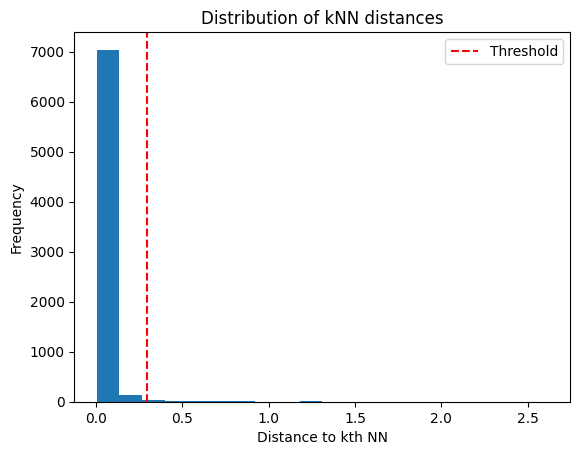

In [ ]:


# Plot a histogram of the kNN distances
plt.hist(df_normalized['Distance to kth NN'], bins=20)

# Plot a vertical line to indicate the threshold for outliers
threshold = df_normalized['Distance to kth NN'].quantile(0.99) 
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')

plt.title('Distribution of kNN distances')
plt.xlabel('Distance to kth NN')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# Set the threshold for high values
threshold_high = 0.99

# Filter the rows with high values (potential outliers)
high_value_rows = df_normalized[df_normalized['Distance to kth NN'] > threshold_high]

# Print the rows with high values
print("Rows with high values (potential outliers):")
print(high_value_rows[['Distance to kth NN']].rename_axis('Row number'))


Rows with high values (potential outliers):
            Distance to kth NN
Row number                    
3                     2.616676
13                    2.616676
26                    1.275746
30                    1.466172
36                    1.695541
39                    1.249427
40                    1.286821
70                    1.772322
402                   1.852725
2396                  1.296766
5569                  1.295031


In [ ]:
# Create a boolean column indicating if the row is an outlier
df_normalized['isKNNOutlier'] = df_normalized['Distance to kth NN'] > threshold_high

# Create a string column with the outlier score
df_normalized['KNNOutScore'] = df_normalized['Distance to kth NN'].astype(str)

# Filter and print only the rows where isKNNOutlier is True
outlier_rows = df_normalized[df_normalized['isKNNOutlier'] == True]
print(outlier_rows)


         Score     Kills    Deaths       K/D    Damage  Headshots  \
3     0.000169  0.086997  0.015286  0.535396  0.008909   0.010085   
13    0.000169  0.086997  0.015286  0.535396  0.008909   0.010085   
26    1.000000  0.024811  0.110297  0.021195  0.008814   0.019429   
30    0.000951  0.027644  0.111409  0.023315  0.013359   0.024807   
36    0.002104  1.000000  0.114263  0.827045  0.006636   0.118013   
39    0.001718  0.039826  0.096258  0.039000  0.013514   0.038834   
40    0.000313  0.011355  0.014797  0.072488  0.027026   0.007626   
70    0.001075  0.026588  0.028747  0.087325  1.000000   0.012639   
402   0.000387  0.059141  0.019516  0.285290  0.002405   1.000000   
2396  0.001896  0.046291  0.054837  0.079695  0.009112   0.022103   
5569  0.000815  0.015150  0.032476  0.044086  0.005364   0.013643   

      Dominations  Shots Fired  Shots Hit  Shots Accuracy  ...      Ties  \
3        1.000000     0.000970   0.001024        0.247812  ...  0.395972   
13       1.000000  

Top 10 outliers:
      Row Number  Outlier Score
5426        5427              1
4097        4098              1
1587        1588              1
5804        5805              1
3316        3317              1
1606        1607              1
505          506              1
5781        5782              1
1617        1618              1
6843        6844              1


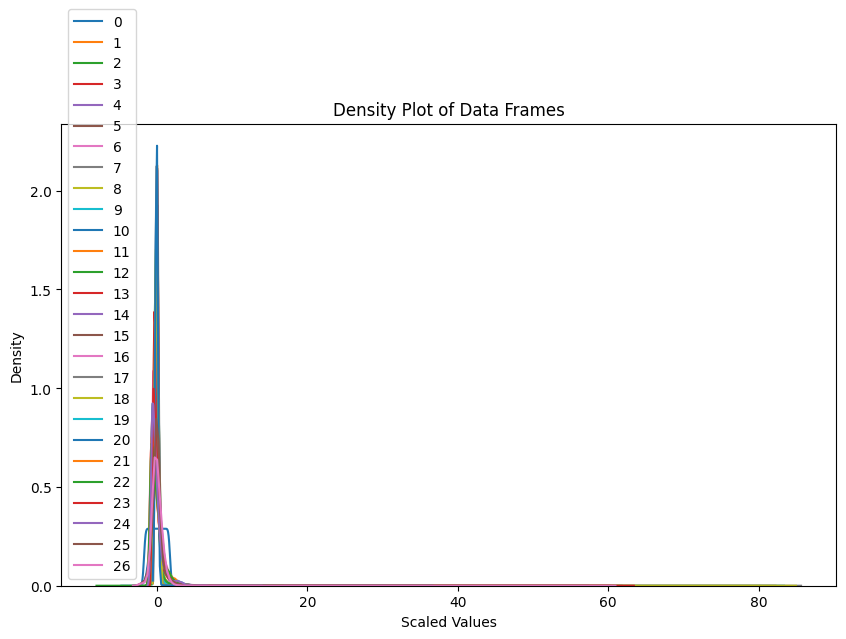

In [ ]:

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=5, contamination='auto', metric='euclidean')

# Fit the model to the data and predict outlier scores
outlier_scores = -lof.fit_predict(df_scaled)

# Create a DataFrame with row numbers and outlier scores
outliers = pd.DataFrame({'Row Number': df.index, 'Outlier Score': outlier_scores})

# Sort the DataFrame by the outlier scores
outliers_sorted = outliers.sort_values(by='Outlier Score', ascending=False)

# Print the top 10 outliers with row numbers and scores
print("Top 10 outliers:")
print(outliers_sorted.head(10))

# Plot density distribution of the data frames
plt.figure(figsize=(10, 6))
for col in df_scaled.columns:
    sns.kdeplot(df_scaled[col], label=col)
plt.title("Density Plot of Data Frames")
plt.xlabel("Scaled Values")
plt.ylabel("Density")
plt.legend()
plt.show()


Local Outlier Factor (LOF)

In [ ]:
#LOF

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=70, contamination='auto', metric='euclidean')

# Fit the model to the data and predict outlier scores
outlier_scores = -lof.fit_predict(df_scaled)

# Create a DataFrame with row numbers and outlier scores
outliers = pd.DataFrame({ 'Outlier Score': outlier_scores})

# Sort the DataFrame by the outlier scores
outliers_sorted = outliers.sort_values(by='Outlier Score', ascending=False)

# Print the top 10 outliers with row numbers and scores
print("Top 10 outliers based on LOF:")
print(outliers_sorted.head(10))

Top 10 outliers based on LOF:
      Outlier Score
0                 1
4860              1
497               1
1024              1
4136              1
1023              1
6877              1
3466              1
6875              1
2689              1


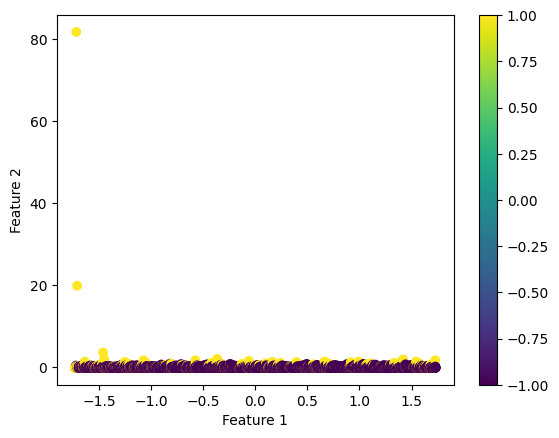

In [ ]:
# LOF
# Fit the LOF model to the data and predict outlier scores
lof = LocalOutlierFactor(n_neighbors=70, contamination='auto', metric='euclidean')
outlier_scores = -lof.fit_predict(df_scaled)

# Create a scatter plot of the data points with their LOF scores as the color
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=outlier_scores)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

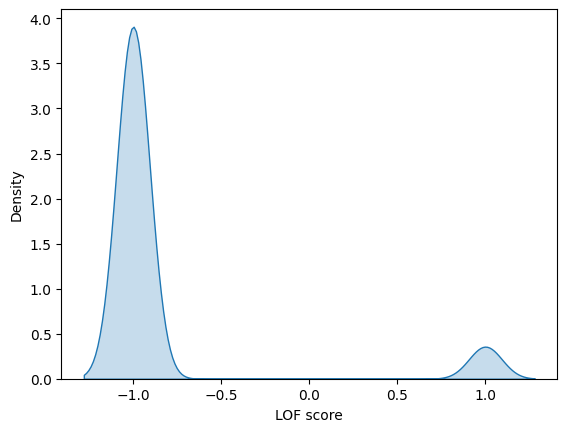

In [ ]:

# Fit the LOF model to the data and predict outlier scores
lof = LocalOutlierFactor(n_neighbors=70, contamination='auto', metric='euclidean')
outlier_scores = -lof.fit_predict(df_scaled)

# Create a density plot of the LOF scores
sns.kdeplot(data=outlier_scores, fill=True)
plt.xlabel('LOF score')
plt.show()


In [ ]:
# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=5, contamination='auto', metric='euclidean')

# Fit the model to the data and predict outlier scores
outlier_scores = -lof.fit_predict(df_scaled)

# Create a boolean column indicating if the row is an LOF outlier
df['isLOFOutlier'] = outlier_scores > 0.9

# Create a string column with the LOF outlier score
df['LOFOutScore'] = outlier_scores.astype(str)

# Filter and print only the rows where isLOFOutlier is True
outlier_rows = df[df['isLOFOutlier'] == True]
print(outlier_rows)



           0         1         2        3      4           5        6  \
2        1.0   37177.0   23354.0  16610.0   1.41  12424189.0   5104.0   
4        3.0   20899.0  206371.0  16340.0  12.63   8809755.0  13478.0   
8        7.0   54648.0   57721.0  22386.0   2.58   3606556.0  16042.0   
12      11.0   37177.0   23354.0  16610.0   1.41  12424189.0   5104.0   
14      13.0   20899.0  206371.0  16340.0  12.63   8809755.0  13478.0   
...      ...       ...       ...      ...    ...         ...      ...   
7229  7228.0  227056.0   52514.0  29721.0   1.77   6931638.0  19313.0   
7233  7232.0  294428.0   86848.0  73496.0   1.18  12331749.0  23380.0   
7242  7241.0   26605.0    7293.0   6543.0   1.11    985352.0   1627.0   
7247  7246.0   12039.0    5343.0   9636.0   0.55    761909.0   2551.0   
7254  7253.0   40959.0   21392.0  15764.0   1.36   3404546.0  10854.0   

               7          8          9  ...      19      20       21      22  \
2         2956.0  2156088.0  1385405.0  ...

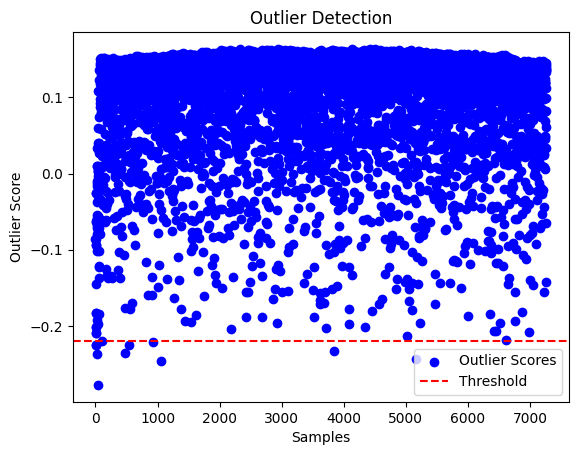

In [ ]:
# Convert column names to strings
df.columns = df.columns.astype(str)

# Initialize the Isolation Forest model
clf = IsolationForest()
clf.fit(df)

# Obtain the outlier scores
outlier_scores = clf.decision_function(df)

# Define the threshold
threshold = -0.22

# Select the outliers based on the threshold
outliers = df[outlier_scores < threshold]

# Create a scatter plot of the outlier scores
plt.scatter(range(len(outlier_scores)), outlier_scores, c='blue', label='Outlier Scores')

# Draw a horizontal line for the threshold
plt.axhline(y=threshold, c='red', linestyle='--', label='Threshold')

# Set labels and title
plt.xlabel('Samples')
plt.ylabel('Outlier Score')
plt.title('Outlier Detection')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create a DataFrame with the outlier scores and isOutlier column
df_outliers_ISOF = pd.DataFrame({'ISOFoutScore': outlier_scores, 'isOutlierISOF': outlier_scores < threshold})

# Filter and print only the rows where isOutlier is True
outliers_true = df_outliers_ISOF[df_outliers_ISOF['isOutlierISOF'] == True]
print(outliers_true)

# Count the number of outliers
outlier_count = outliers_true.shape[0]

# Print the count
print("Number of outliers:", outlier_count)


      ISOFoutScore  isOutlierISOF
3        -0.225519           True
13       -0.225519           True
30       -0.236405           True
36       -0.277505           True
472      -0.235408           True
543      -0.224818           True
929      -0.221055           True
1053     -0.245536           True
3844     -0.232687           True
5159     -0.242875           True
Number of outliers: 10


PCA

In [ ]:
#PCA
# Estimate the center and covariance matrix using the MCD estimator
mcd = MinCovDet(support_fraction=0.9999999).fit(df)
center = mcd.location_
covariance = mcd.covariance_

# Compute the Mahalanobis distance for each observation
distances = []
for i in range(len(df)):
    x = df.iloc[i].values
    distances.append(mahalanobis(x, center, np.linalg.inv(covariance)))

# Replace missing values with the mean value
distances_no_missing = np.nan_to_num(distances, nan=np.nanmean(distances))

# Standardize the data
data_std = StandardScaler().fit_transform(df)

# Apply PCA to the standardized data
pca = PCA()
pca.fit(data_std)

# Compute the scores of each observation on the principal components
scores = pca.transform(data_std)

# Determine outliers based on Mahalanobis distances and PCA scores
threshold = 6000 # Example threshold value
outliers = np.argwhere(np.array(distances_no_missing) > threshold)

# Compute the outlier score for each outlier
mean_distance = np.mean(distances_no_missing)
std_distance = np.std(distances_no_missing)
outlier_scores = []
for outlier in outliers.flatten():
    outlier_distance = distances_no_missing[outlier]
    normalized_distance = (outlier_distance - mean_distance) / std_distance
    outlier_scores.append(normalized_distance)

# Get the indices of the top 15 outliers (if there are at least 15 outliers)
if len(outliers) >= 15:
    top_outliers = np.argsort(outlier_scores)[-15:]
else:
    top_outliers = np.argsort(outlier_scores)

# Print the outlier score for each of the top 15 outliers
for i, outlier in enumerate(outliers.flatten()[top_outliers]):
    print("Outlier", i+1, "score:", outlier_scores[outlier])



/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


LinAlgError: ignored

In [ ]:
# Sort the outlier scores in descending order
sorted_indices = np.argsort(outlier_scores)[::-1]

# Print the top 20 outliers based on outlier score
print("Top 20 outliers based on outlier score:")
for i in range(min(20, len(sorted_indices))):
    outlier_index = outliers[sorted_indices[i]].item()
    outlier_score = outlier_scores[sorted_indices[i]]
    print("Outlier index:", outlier_index, "Outlier score:", outlier_score)

# Print the bottom 20 outliers based on outlier score
print("Bottom 20 outliers based on outlier score:")
for i in range(min(20, len(sorted_indices))):
    outlier_index = outliers[sorted_indices[-i-1]].item()
    outlier_score = outlier_scores[sorted_indices[-i-1]]
    print("Outlier index:", outlier_index, "Outlier score:", outlier_score)

Top 20 outliers based on outlier score:
Outlier index: 30 Outlier score: 52.902560494442845
Outlier index: 13 Outlier score: 44.56097986601451
Outlier index: 3 Outlier score: 44.56097986601451
Outlier index: 6 Outlier score: 6.194324439509933
Outlier index: 15 Outlier score: 6.194324439509933
Outlier index: 37 Outlier score: 3.8002424392202445
Outlier index: 1622 Outlier score: 3.390487358271224
Outlier index: 6514 Outlier score: 3.245407813065121
Outlier index: 5884 Outlier score: 2.892378006821123
Outlier index: 11 Outlier score: 2.506392259135088
Outlier index: 1 Outlier score: 2.506392259135088
Outlier index: 2191 Outlier score: 2.493297552941029
Outlier index: 2396 Outlier score: 2.493099217495968
Outlier index: 3899 Outlier score: 2.472676884560277
Outlier index: 6450 Outlier score: 2.4494750652792368
Outlier index: 4082 Outlier score: 2.4013818464311285
Outlier index: 6814 Outlier score: 2.3579680830009813
Outlier index: 3519 Outlier score: 2.3472939954129926
Outlier index: 7045

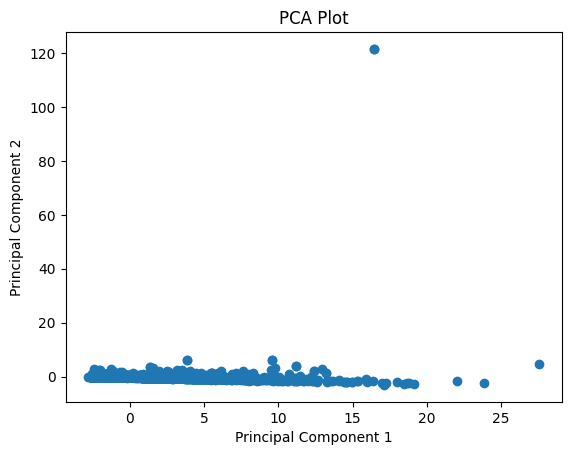

In [ ]:

# Plot the first two principal components
plt.scatter(scores[:, 0], scores[:, 1])

# Add axis labels and a title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')

# Show the plot
plt.show()


<ipython-input-41-80b5467ab86f>:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_pca[:, 0], label=f"PC1 (explained variance = {variances[0]:.2f})", shade=True)
<ipython-input-41-80b5467ab86f>:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_pca[:, 1], label=f"PC2 (explained variance = {variances[1]:.2f})", shade=True)


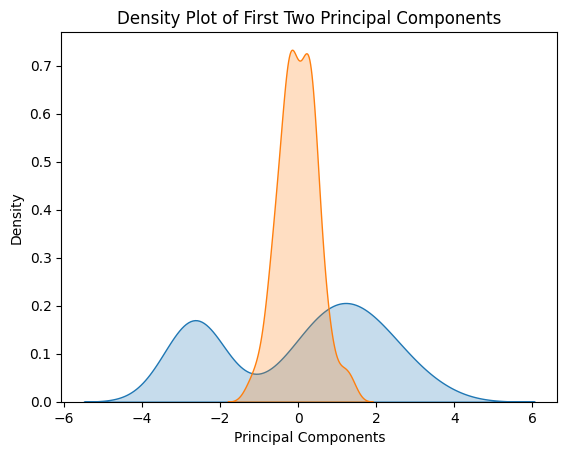

In [ ]:

# Load and preprocess the data
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Fit the PCA model to the data
pca = PCA()
X_pca = pca.fit_transform(X)

# Compute the explained variances of the principal components
variances = pca.explained_variance_ratio_

# Plot the density lines of the first two principal components
sns.kdeplot(X_pca[:, 0], label=f"PC1 (explained variance = {variances[0]:.2f})", shade=True)
sns.kdeplot(X_pca[:, 1], label=f"PC2 (explained variance = {variances[1]:.2f})", shade=True)

# Set the title and axis labels
plt.title("Density Plot of First Two Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Density")

# Display the plot
plt.show()


In [ ]:
# Estimate the center and covariance matrix using the MCD estimator
mcd = MinCovDet(support_fraction=0.9999999).fit(df)
center = mcd.location_
covariance = mcd.covariance_

# Compute the Mahalanobis distance for each observation
distances = []
for i in range(len(df)):
    x = df.iloc[i].values
    distances.append(mahalanobis(x, center, np.linalg.inv(covariance)))

# Replace missing values with the mean value
distances_no_missing = np.nan_to_num(distances, nan=np.nanmean(distances))

# Standardize the data
data_std = StandardScaler().fit_transform(df)

# Apply PCA to the standardized data
pca = PCA()
pca.fit(data_std)

# Compute the scores of each observation on the principal components
pca_scores = pca.transform(data_std)

# Determine outliers based on the PCA scores
threshold = 20  # Adjust the threshold value according to your specific requirements
outliers = np.argwhere(np.sum(pca_scores**2, axis=1) > threshold**2)

# Create a boolean column indicating if the row is a PCA outlier
df['isOutlierPCA'] = False
df.iloc[outliers.flatten(), df.columns.get_loc('isOutlierPCA')] = True

# Create a string column with the PCA outlier score
df['PCAOutScore'] = np.sum(pca_scores**2, axis=1).astype(str)

# Print the rows that are outliers
outliers_df = df[df['isOutlierPCA'] == True]
print(outliers_df[['isOutlierPCA', 'PCAOutScore']])

# Count the number of outliers
outlier_count = len(outliers)
print("Number of outliers based on PCA:", outlier_count)

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:745: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


LinAlgError: ignored

# PART 3: Results: Majority Voting

In [ ]:
# Define the list of column names for each ML technique
column_names = ['PCAOutScore', 'ISOFOutScore', 'LOFOutScore', 'KNNOutScore', 'MahanOutScore']

# Create an empty dictionary to store the outlier votes
outlier_votes = {}

# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    outlier_count = 0
    for column in column_names:
        if row[column] == True:
            outlier_count += 1

    # Store the outlier count for the row
    outlier_votes[index] = outlier_count

# Set the threshold for majority voting
threshold = len(column_names) / 2

# Create a boolean column for majority voting
df['isOutlierMajority'] = False
df.loc[list(outlier_votes.keys()), 'isOutlierMajority'] = [votes > threshold for votes in outlier_votes.values()]

# Print the rows that are outliers based on majority voting
outliers_majority = df[df['isOutlierMajority'] == True]
print(outliers_majority)

KeyError: ignored